This file contains python code to check the hypothesis testing

In [1]:
RUN_PYTHON_SCRIPT = False
#OUTLIER_IDXS = dict(AD=[], ctrl=[])
OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
SAVED_FOLDER = "real_data_nlinear_nostd"
DATA = ["AD88_matlab_1-45.pkl", "Ctrl92_matlab_1-45.pkl"]

['AD88_matlab_1-45.pkl', 'Ctrl92_matlab_1-45.pkl']

In [2]:
import sys
sys.path.append("../../mypkg")


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import itertools

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
from IPython.display import display
from joblib import Parallel, delayed

In [4]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [5]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.likelihood import obt_lin_tm
from utils.misc import save_pkl, load_pkl

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)
def_dtype = torch.get_default_dtype()

torch.float64

# Load  data and prepare

In [8]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
df0= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
df1= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt_more.csv");
df1 = df1.set_index("RID")
df0 = df0.set_index("RID");
df1 = df1.reindex(df0.index)
baseline = df1
baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_matlab_1-45.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_matlab_1-45.pkl


In [9]:
# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = 10*np.log10(raw_X);
outlier_idxs2 = np.where(X_dB.mean(axis=(1, 2))<0)
#X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);
X = X_dB

Y = np.array(baseline["MMSE"])[:X.shape[0]];
# if logi
Yb = np.array(baseline["Grp_binary"])[:X.shape[0]];

sel_cov = ["Gender_binary", "MEG_Age","Education"]
Z_raw = np.array(baseline[sel_cov])[:X.shape[0]];

grp_idxs = np.array(baseline["Grp"])[:X.shape[0]];


outlier_idxs = np.sort(np.union1d(outlier_idxs, outlier_idxs2))


# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)
Yb = np.delete(Yb, outlier_idxs, axis=0)
Z_raw = np.delete(Z_raw, outlier_idxs, axis=0)
grp_idxs = np.delete(grp_idxs, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.bitwise_or(np.isnan(Y), np.isnan(Z_raw.sum(axis=1)));
X = X[keep_idx];
Y = Y[keep_idx]
Yb = Yb[keep_idx]
Z_raw = Z_raw[keep_idx]
grp_idxs = grp_idxs[keep_idx]

Z = np.concatenate([np.ones((Z_raw.shape[0], 1)), Z_raw], axis=1); # add intercept


freqs = AD_PSD.freqs;
# only take PSD between [2, 35] freqs of interest
X = X[:, :, np.bitwise_and(freqs>=2, freqs<=35)]
X = X/X.mean()


print(X.shape, Y.shape, Z.shape)

all_data = edict()
if SAVED_FOLDER.endswith("X1err"):
    all_data.X = torch.tensor(X+np.random.randn(*X.shape)*0.1)
else:
    all_data.X = torch.tensor(X)
all_data.Y = torch.tensor(Y)
all_data.Z = torch.tensor(Z)


(143, 68, 74) (143,) (143, 4)


In [10]:
# atlas
rois = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);

# Param and fns

## Params

In [11]:
from easydict import EasyDict as edict
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from copy import deepcopy
from scenarios.base_params import get_base_params

base_params = get_base_params("linear") 
base_params.data_params = edict()
base_params.data_params.d = all_data.X.shape[1]
base_params.data_params.n = all_data.X.shape[0]
base_params.data_params.npts = all_data.X.shape[-1]
base_params.data_params.freqs = AD_PSD.freqs[np.bitwise_and(freqs>=2, freqs<=35)]

base_params.can_Ns = [4, 6, 8, 10, 12, 14]
base_params.SIS_params = edict({"SIS_pen": 0.02, "SIS_basis_N":8, "SIS_ws":"simpson"})
base_params.opt_params.beta = 10 
base_params.can_lams = [0.60,  0.80,  1,  1.2, 1.4, 1.6, 2.0, 4.0]


setting = edict(deepcopy(base_params))
add_params = edict({})
add_params.setting = "real_data_linear"
add_params.SIS_ratio = 1
setting.update(add_params)

In [12]:
save_dir = RES_ROOT/SAVED_FOLDER
if not save_dir.exists():
    save_dir.mkdir()

In [13]:
bands_cut = edict()
bands_cut.delta = [2, 4]
bands_cut.theta = [4, 8]
bands_cut.alpha = [8, 12]
bands_cut.beta = [12, 35]
bands_cut.pts = [4, 8, 12, 35]

cut_pts = np.abs(freqs.reshape(-1, 1) - bands_cut.pts).argmin(axis=0)

array([ 7, 16, 25, 76])

# Analysis

In [131]:
import matplotlib.patches as mpatches
from nilearn import plotting
import matplotlib as mpl
from utils.brain_plot import get_bg_data

In [132]:
def _get_sig_bds(lows, ups):
    """Get sig bds based on lows and ups CI bds
    """
    insig_idxs = np.bitwise_and(lows<=0, ups>=0)
    insig_idxs_num = np.where(insig_idxs)[0]
    idxs = np.where(np.diff(insig_idxs_num)>1)[0]
    bds = [(insig_idxs_num[ix], insig_idxs_num[ix+1]) for ix in idxs]
    if insig_idxs_num[0] > 0:
        bds.append((0, insig_idxs_num[0]))
    if insig_idxs_num[-1] < (len(ups)-1):
        bds.append((insig_idxs_num[-1], len(ups)-1))
    bds = sorted(bds, key=lambda x: x[0])
    return bds

In [133]:

def _brain_plot(vec, cmap="Reds", threshold=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.43
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    vmin, vmax = np.min(vec), np.max(vec)
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 10))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    fig.text(0.12, 0.30, 'Medial', ha='center', va='center')
    fig.text(0.12, 0.72, 'Lateral', ha='center', va='center')
    fig.text(0.30, 0.87, 'Left', ha='center', va='center')
    fig.text(0.72, 0.87, 'Right', ha='center', va='center')
    #plt.suptitle("-log pvalues", fontsize=30)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    fig.colorbar(sm, cax=cbar_ax)
    return fig

In [134]:
def _filname2set(fil):
    """Based on the file name, reture the setting"""
    res = edict()
    for curstr in fil.stem.split("-"):
        vs = curstr.split("_")
        if vs[0] == "lam":
            res[vs[0]] = int(vs[1])/1000
        else:
            res[vs[0]] = int(vs[1])
    return res
tNs = []
tlams = []
for fil in save_dir.glob(f"roi_*.pkl"):
    tmp = _filname2set(fil)
    tNs.append(tmp["N"])
    tlams.append(tmp["lam"])
np.sort(np.unique(tNs)),  np.sort(np.unique(tlams))

(array([ 4,  6,  8, 10, 12, 14]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4]))

In [135]:
from utils.misc import get_local_min_idxs
def _argmin_last2d(arr):
    """
    Find the minimum value positions along the last two dimensions of a 2D array.

    Args:
    arr (numpy.ndarray): Input 2D array.

    Returns:
    tuple: Indices of the minimum values along the last two dimensions.
    """
    arr_reshaped = arr.reshape(arr.shape[0], -1)
    min_positions_linear = np.argmin(arr_reshaped, axis=1)
    min_positions = np.unravel_index(min_positions_linear, arr.shape[1:])
    return min_positions
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
def _Nlam_localmin(err_mat, Ns, lams):
    min_idxs = []
    for err_vec in err_mat:
        min_idxs.append([_get_min_idx(err_vec), 
                         err_vec[_get_min_idx(err_vec)]])
    min_idxs = np.array(min_idxs)
    best_idx = np.argmin(min_idxs[:, 1])
    best_N = Ns[best_idx]
    best_lam = lams[int(min_idxs[best_idx, 0])]
    return (best_N, best_lam)

In [136]:
from scipy.stats import chi2
lams = np.sort(np.unique(tlams))
lams = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3]
Ns = np.array([4, 6, 8, 10, 12, 14])
log_cv = np.log(0.05/68);

In [137]:
errs = load_pkl(RES_ROOT/f"{SAVED_FOLDER}/errs_mse_roi_N_lam.pkl");
errs_dict = {v[0]:v[1] for v in errs};
# sel the lams based on the CV errors
errs_arr = []
for roi_ix in trange(68):
    errs_N = []
    for N in Ns:
        errs_lam = []
        for lam in lams:
            mse = errs_dict[(roi_ix, lam, N)]
            errs_lam.append(mse)
        errs_N.append(errs_lam)
    errs_arr.append(errs_N)
errs_arr = np.array(errs_arr); #nroi x nN x nlam x nsub

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../results/real_data_nlinear_nostd/errs_mse_roi_N_lam.pkl


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 62192.03it/s]


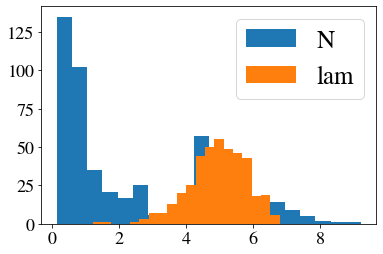

In [138]:
plt.hist(errs_arr.std(axis=1).reshape(-1), bins=20, label="N")
plt.hist(errs_arr.std(axis=2).reshape(-1), bins=20, label="lam");
plt.legend()

## Select with mse

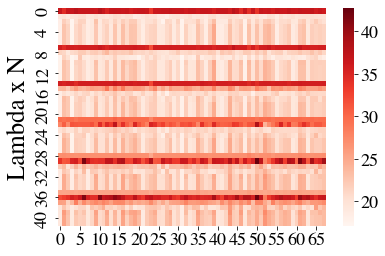

In [139]:
if not RUN_PYTHON_SCRIPT:
    sns.heatmap(errs_arr.reshape(68, -1).T, cmap="Reds")
    plt.ylabel("Lambda x N");

In [140]:
sel_Nlams_mse = []
for roi_ix in range(68):
    sel_Nlams_mse.append(_Nlam_localmin(errs_arr[roi_ix], Ns, lams))
sel_Nlams_mse = np.array(sel_Nlams_mse);

#min_idxs = _argmin_last2d(errs_arr);
#sel_Nlams_mse = np.zeros((68, 2))
#for roi_ix in range(68):
#    sel_Nlams_mse[roi_ix, 0] = Ns[min_idxs[0][roi_ix]]
#    sel_Nlams_mse[roi_ix, 1] = lams[min_idxs[1][roi_ix]]

In [152]:
T_vs = []
keep_rois = []
pvals = []
for roi_ix in trange(68):
    errs = []
    N, lam = sel_Nlams_mse[roi_ix]
    fil = save_dir/f"roi_{roi_ix}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    hdf_res = load_pkl(fil, verbose=False)
    hdf_res.verbose=1
    test_res = hdf_res.hypo_test(Cmat=np.eye(1))
    T_vs.append(test_res.T_v.item())
    pvals.append(test_res.pval)
    keep_rois.append((hdf_res.est_Gam.norm(dim=0) != 0).numpy().astype(int))
keep_rois = np.array(keep_rois)
T_vs = np.array(T_vs);
pvals = np.array(pvals);

  0%|                                                                                                                                                                                  | 0/68 [00:00<?, ?it/s]2024-03-15 15:17:32,478 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.
2024-03-15 15:17:32,496 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.
2024-03-15 15:17:32,511 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.
2024-03-15 15:17:32,529 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.
2024-03-15 15:17:32,549 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.
2024-03-15 15:17:32,566 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'sv

In [153]:
np.sum(pvals <= 0.05/68)

19

In [175]:
max_idxs = np.max(np.where(np.sort(pvals) <=  np.arange(1, len(pvals)+1)/68 * 0.05)[0])
sig_roi_idxs_bh = np.sort(np.argsort(pvals)[:max_idxs+1]);
p1 = sig_roi_idxs_bh[sig_roi_idxs_bh<34]
p2 = sig_roi_idxs_bh[sig_roi_idxs_bh>=34]-34
np.intersect1d(p1, p2)

array([ 3,  7,  8, 13, 21, 25, 26, 29])

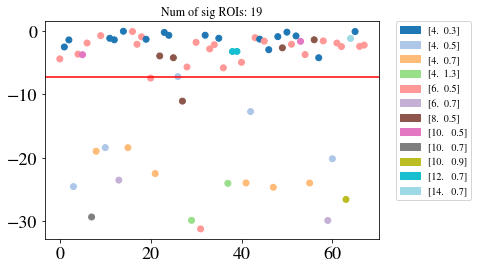

In [176]:
unique_coms = np.unique(sel_Nlams_mse, axis=0)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_coms)));
point_colors = [ colors[np.abs(unique_coms - val).sum(axis=-1)==0].squeeze() 
                for val in sel_Nlams_mse];

log_pvs = chi2.logsf(T_vs, df=sel_Nlams_mse[:, 0])

plt.title(f"Num of sig ROIs: {np.sum(log_pvs<log_cv):.0f}")
plt.scatter(x=np.arange(68), y=log_pvs, c=point_colors)
plt.axhline(y=log_cv, color="red")

patches = [mpatches.Patch(color=colors[np.abs(unique_coms - val).sum(axis=-1)==0].squeeze(), label=str(val)) for val in unique_coms]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1, fontsize=10)


In [180]:
np.sort(log_pvs)

array([-31.18604903, -29.8567418 , -29.83522536, -29.30920356,
       -26.54464021, -24.64003019, -24.5286616 , -24.01546306,
       -23.96643946, -23.95089568, -23.50626642, -22.47651446,
       -20.15259586, -18.96142783, -18.40123132, -18.39265732,
       -12.72641352, -11.07819349,  -7.45507728,  -7.21248509,
        -5.83980886,  -5.71093276,  -4.97515239,  -4.4376151 ,
        -4.25551275,  -4.25205157,  -3.97122202,  -3.77505723,
        -3.75327942,  -3.69126699,  -3.27254115,  -3.25641803,
        -2.99146754,  -2.86912835,  -2.69453455,  -2.56018534,
        -2.49907727,  -2.46331182,  -2.26783409,  -2.20263112,
        -2.13581415,  -2.1333331 ,  -1.9401947 ,  -1.93708478,
        -1.83135404,  -1.67278614,  -1.64085577,  -1.60393025,
        -1.44818664,  -1.43647978,  -1.42839161,  -1.34865067,
        -1.3251668 ,  -1.22296805,  -1.19505829,  -1.18904041,
        -1.1019294 ,  -0.96707023,  -0.93432823,  -0.81998272,
        -0.78227447,  -0.72428252,  -0.71336499,  -0.26

In [178]:
np.sum(vec_plot!=0)

27

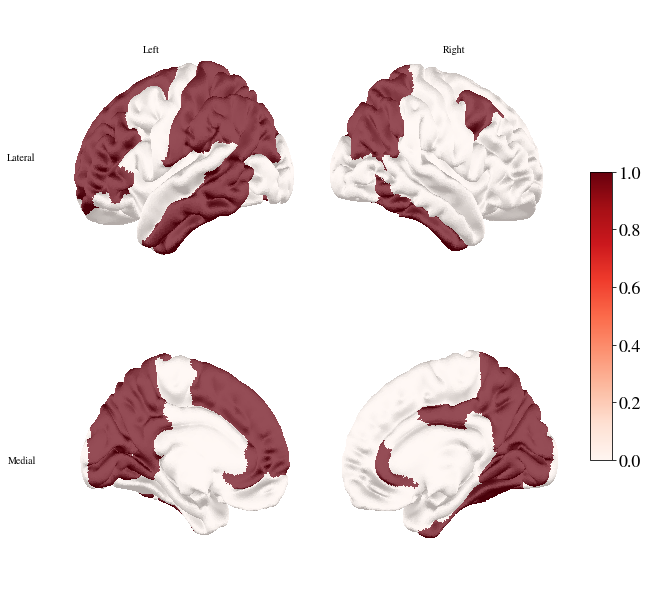

In [184]:
vec = -log_pvs
vec_plot = np.zeros(len(vec))
#vec = (vec-vec.min())/(np.quantile(vec, 0.9)-vec.min())
#vec = (vec-vec.min())/(vec.max()-vec.min())
#vec_plot[sig_roi_idxs_bh] = vec[sig_roi_idxs_bh]
vec_plot[sig_roi_idxs_bh] = 1
#vec[vec>1] = 1
cmap = "Reds"
fig = _brain_plot(vec_plot, cmap=cmap);
#plt.savefig(FIG_ROOT/f"{SAVED_FOLDER}_pval_brain_plot.jpg")

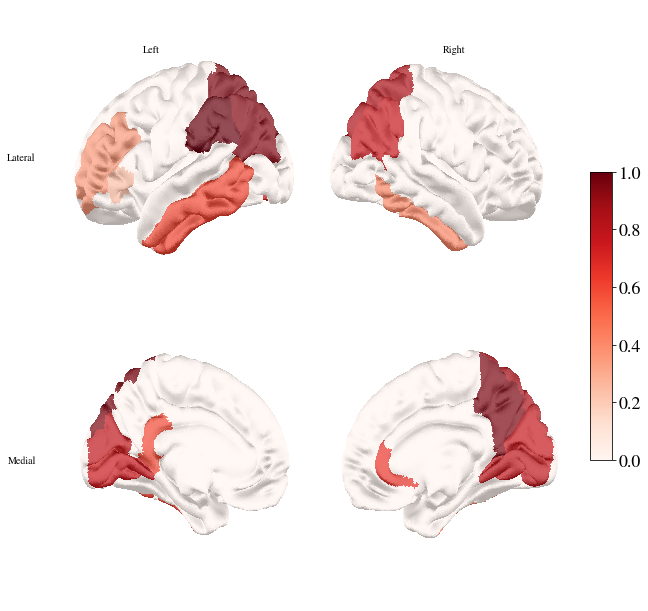

In [143]:
vec = -log_pvs
#vec = (vec-vec.min())/(np.quantile(vec, 0.9)-vec.min())
vec = (vec-vec.min())/(vec.max()-vec.min())
vec[log_pvs>=np.log(0.05/68)] = 0
#vec[vec>1] = 1
cmap = "Reds"
fig = _brain_plot(vec, cmap=cmap);
plt.savefig(FIG_ROOT/f"{SAVED_FOLDER}_pval_brain_plot.jpg")

In [144]:
# save the sig roi idx 
sig_roi_idxs = np.where(log_pvs <= np.log(0.05/68))[0];
#save_pkl(RES_ROOT/f"{SAVED_FOLDER}/sig_roi_idxs.pkl", sig_roi_idxs, is_force=True)

In [145]:
np.intersect1d(sig_roi_idxs[sig_roi_idxs<34], sig_roi_idxs[sig_roi_idxs>=34]-34)

array([ 3,  7,  8, 13, 21, 29])

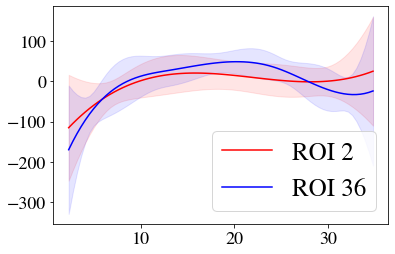

In [151]:
import scipy.stats as stats
def _get_est_beta(roi_ix, alpha=0.05/68):
    qv = np.abs(stats.norm.ppf(alpha/2))
    fil = save_dir/f"roi_{roi_ix}-lam_{sel_Nlams_mse[roi_ix, 1]*1000:.0f}-N_{sel_Nlams_mse[roi_ix, 0]:.0f}_fit.pkl"
    hdf_res = load_pkl(fil, verbose=False);
    basis_mat = hdf_res.obt_bsp(np.linspace(0, 1, hdf_res.data_params.npts), 
                    hdf_res.bsp_params.N, 
                    hdf_res.bsp_params.basis_ord)
        
    est_beta = (basis_mat @ hdf_res.est_Gam.numpy())[:, roi_ix]
    cov_mat = hdf_res.get_covmat(rtol=1e-7).beta.numpy()
    cov_mat_beta = basis_mat @ cov_mat @ basis_mat.T;
    
    lows = est_beta - np.sqrt(np.diag(cov_mat_beta))*qv
    ups = est_beta + np.sqrt(np.diag(cov_mat_beta))*qv
    return est_beta, lows, ups

roi_ix1 = 2
roi_ix2 = 2+34
beta_est1, lows1, ups1 = _get_est_beta(roi_ix1)
beta_est2, lows2, ups2 = _get_est_beta(roi_ix2);
#plt.plot(beta_est1)
#plt.plot(beta_est2)
plt.plot(setting.data_params.freqs, beta_est1, color="red", label=f"ROI {roi_ix1}")
plt.fill_between(setting.data_params.freqs, lows1, ups1, color="red", alpha=0.1)
plt.plot(setting.data_params.freqs, beta_est2, color="blue", label=f"ROI {roi_ix2}")
plt.fill_between(setting.data_params.freqs, lows2, ups2, color="blue", alpha=0.1)
plt.legend()

### CI

In [27]:
import scipy.stats as stats
qv = np.abs(stats.norm.ppf(0.025/68))
# select the results
num_sig = np.sum(log_pvs<log_cv)
sorted_idxs = np.argsort(log_pvs);
sig_list = []
for ix in trange(68):
    roi_sel = sorted_idxs[ix];
    fil = save_dir/f"roi_{roi_sel}-lam_{sel_Nlams_mse[roi_sel, 1]*1000:.0f}-N_{sel_Nlams_mse[roi_sel, 0]:.0f}_fit.pkl"
    hdf_res = load_pkl(fil, verbose=False);
    basis_mat = hdf_res.obt_bsp(np.linspace(0, 1, hdf_res.data_params.npts), 
                hdf_res.bsp_params.N, 
                hdf_res.bsp_params.basis_ord)
    
    est_beta = (basis_mat @ hdf_res.est_Gam.numpy())[:, roi_sel]
    cov_mat = hdf_res.get_covmat(rtol=1e-7).beta.numpy()
    cov_mat_beta = basis_mat @ cov_mat @ basis_mat.T;
    
    lows = est_beta - np.sqrt(np.diag(cov_mat_beta))*qv
    ups = est_beta + np.sqrt(np.diag(cov_mat_beta))*qv
    
    bds = _get_sig_bds(lows, ups)
    sig_list.append(1-np.bitwise_and(lows<=0, ups>=0))
    
sig_list = np.array(sig_list)
sorted_rois = rois[sorted_idxs]
sorted_pvs = np.exp(log_pvs[sorted_idxs]);

  0%|                                                                                                                                                                                  | 0/68 [00:00<?, ?it/s]R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 59.22it/s]


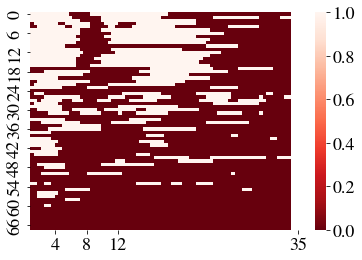

In [28]:
sns.heatmap(sig_list[:], cmap="Reds_r")
plt.xticks(cut_pts, bands_cut.pts);

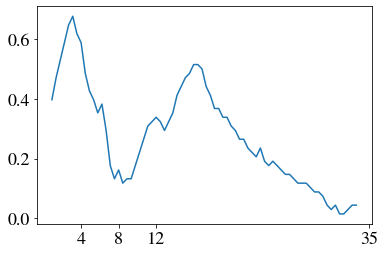

In [29]:
plt.plot(sig_list[:].mean(axis=0))
plt.xticks(cut_pts, bands_cut.pts);

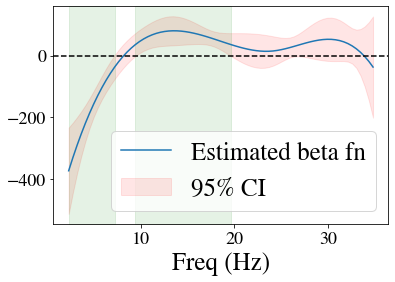

In [30]:
if not RUN_PYTHON_SCRIPT:
    roi_sel = sorted_idxs[0];
    fil = save_dir/f"roi_{roi_sel}-lam_{sel_Nlams_mse[roi_sel, 1]*1000:.0f}-N_{sel_Nlams_mse[roi_sel, 0]:.0f}_fit.pkl"
    hdf_res = load_pkl(fil, verbose=False);
    basis_mat = hdf_res.obt_bsp(np.linspace(0, 1, hdf_res.data_params.npts), 
                hdf_res.bsp_params.N, 
                hdf_res.bsp_params.basis_ord)
    
    est_beta = (basis_mat @ hdf_res.est_Gam.numpy())[:, roi_sel]
    cov_mat = hdf_res.get_covmat(rtol=1e-7).beta.numpy()
    cov_mat_beta = basis_mat @ cov_mat @ basis_mat.T;
    
    lows = est_beta - np.sqrt(np.diag(cov_mat_beta))*qv
    ups = est_beta + np.sqrt(np.diag(cov_mat_beta))*qv
    
    bds = _get_sig_bds(lows, ups)
    
    plt.plot(setting.data_params.freqs, est_beta, label="Estimated beta fn")
    plt.fill_between(setting.data_params.freqs, lows, ups, color="red", alpha=0.1, label="95% CI")
    
    if False:
        freq_data_sel = all_data.X[:, roi_sel];
        freq_data_sel_AD = freq_data_sel[grp_idxs=="AD"].mean(axis=0)
        freq_data_sel_ctrl = freq_data_sel[grp_idxs=="Ctrl"].mean(axis=0)
        plt.plot(setting.data_params.freqs, freq_data_sel_AD-freq_data_sel_ctrl, label="AD-Ctrl")
    
    y_min, y_max = plt.ylim()
    for bd in bds: 
        x1, x2 = setting.data_params.freqs[bd[0]], setting.data_params.freqs[bd[1]]
        plt.fill_betweenx([y_min, y_max], x1=x1, x2=x2, color='green', alpha=0.1)
    plt.axhline(y=0, ls="--", color="black")
    plt.ylim([y_min, y_max])
    plt.xlabel("Freq (Hz)")
    plt.legend()

## Results when using sig rois


In [49]:
def _extract_err1(lam, N):
    fil = save_dir/f"sigroi-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    hdf_res = load_pkl(fil, verbose=False);
    mse = np.mean((hdf_res.cv_Y_est - hdf_res.Y.numpy())**2)
    return mse
sigroi_errs = np.zeros((len(Ns),len(lams)))
for ix, N in enumerate(Ns):
    for iy, lam in enumerate(lams):
        sigroi_errs[ix, iy] = _extract_err1(lam, N)

In [58]:
optN, optlam = _Nlam_localmin(sigroi_errs)
fil = save_dir/f"sigroi-lam_{optlam*1000:.0f}-N_{optN:.0f}_fit.pkl";
res = load_pkl(fil);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../results/real_data_nlinear_nostd/sigroi-lam_500-N_4_fit.pkl


In [103]:
hypo_res = res.hypo_test(Cmat=np.eye(len(sig_roi_idxs)));
hypo_res

2024-03-11 11:48:15,618 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.,

{'pval': 1.075175203177201e-104, 'T_v': tensor(715.4519)}

In [71]:
def get_ci(est_alp, cov_mat, alp_idx, qv=1.96):
    ci_lim = qv*cov_mat[alp_idx, alp_idx].sqrt().item()
    ci = [est_alp[alp_idx].item()-ci_lim,  est_alp[alp_idx].item()+ci_lim]
    return ci

In [78]:
cov_mat = res.get_covmat()["alpha"];
est_alp = res.est_alp;
cis = {}
for alp_ix in [1, 2, 3]:
    ci = get_ci(est_alp, cov_mat, alp_ix, qv=1.96)
    cis[sel_cov[alp_ix-1]] = ci
cis

{'Gender_binary': [-1.919557545241205, 0.9155024448771749],
 'MEG_Age': [-0.24096804994670518, 1.0174193840101604],
 'Education': [0.15463361046643254, 0.6789327421995597]}

In [17]:
import scipy
scipy.stats.ttest_ind(Z[:, 2][grp_idxs=="AD"],  Z[:, 2][grp_idxs=="Ctrl"])

TtestResult(statistic=-5.649922683573058, pvalue=8.560366703376889e-08, df=141.0)

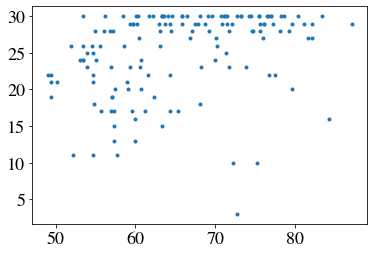

In [102]:
# age analysis
import scipy
scipy.stats.pearsonr(Z[:, 2], Y)
plt.plot(Z[:, 2], Y, ".")

## Sig diff results

In [123]:
hb_sig_roi_idxs = sig_roi_idxs.copy()
hb_sig_roi_idxs[sig_roi_idxs>=34] = sig_roi_idxs[sig_roi_idxs>=34] - 34
hb_sig_roi_idxs = np.sort(np.unique(hb_sig_roi_idxs))

array([ 3,  7,  8, 10, 13, 15, 20, 21, 25, 26, 27, 29, 31])

In [124]:
errs = load_pkl(RES_ROOT/f"{SAVED_FOLDER}/errshb_mse_roi_N_lam.pkl");
errs_dict = {v[0]:v[1] for v in errs};
# sel the lams based on the CV errors
errs_arr = []
for roi_ix in hb_sig_roi_idxs:
    errs_N = []
    for N in Ns:
        errs_lam = []
        for lam in lams:
            mse = errs_dict[(roi_ix, lam, N)]
            errs_lam.append(mse)
        errs_N.append(errs_lam)
    errs_arr.append(errs_N)
errs_arr = np.array(errs_arr); #nroi x nN x nlam

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../results/real_data_nlinear_nostd/errshb_mse_roi_N_lam.pkl


In [125]:
sel_Nlams_mse = []
for ix, roi_ix in enumerate(hb_sig_roi_idxs):
    sel_Nlams_mse.append(_Nlam_localmin(errs_arr[ix], Ns, lams))
sel_Nlams_mse = np.array(sel_Nlams_mse);

In [126]:
Cmat = np.array([1, -1])[None]
T_vs = []
pvals = []
for ix, roi_ix in enumerate(hb_sig_roi_idxs):
    errs = []
    N, lam = sel_Nlams_mse[ix]
    fil = save_dir/f"hbroi_{roi_ix}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    hdf_res = load_pkl(fil, verbose=False)
    hdf_res.verbose=1
    test_res = hdf_res.hypo_test(Cmat=Cmat)
    T_vs.append(test_res.T_v.item())
    pvals.append(test_res.pval)
T_vs = np.array(T_vs);
pvals = np.array(pvals);

2024-03-15 13:46:33,231 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[ 1, -1]])}.
2024-03-15 13:46:33,245 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[ 1, -1]])}.
2024-03-15 13:46:33,257 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[ 1, -1]])}.
2024-03-15 13:46:33,269 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[ 1, -1]])}.
2024-03-15 13:46:33,281 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[ 1, -1]])}.
2024-03-15 13:46:33,293 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[ 1, -1]])}.
2024-03-15 13:46:33,304 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[ 1, 

In [127]:
hb_sig_roi_idxs

array([ 3,  7,  8, 10, 13, 15, 20, 21, 25, 26, 27, 29, 31])

In [128]:
sig_roi_idxs[sig_roi_idxs<34],  sig_roi_idxs[sig_roi_idxs>=34]-34

(array([ 3,  7,  8, 10, 13, 15, 20, 21, 27, 29, 31]),
 array([ 3,  7,  8, 13, 21, 25, 26, 29]))

In [129]:
pvals

array([0.43274562, 0.6334142 , 0.97099935, 0.92579106, 0.29859802,
       0.87866776, 0.58606747, 0.78944961, 0.48053254, 0.79284846,
       0.09566122, 0.45407026, 0.23678264])

# Results from sinica

In [18]:
from scipy.io import loadmat
res_root = RES_ROOT/"sinica_results/real_datapsd_matlab_1-45";
fils = list(res_root.glob("roi*.mat"))
fils = sorted(fils, key=lambda x: int(x.stem.split("_")[0][3:]));
pvals_sini= []
for fil in fils:
    pval = loadmat(fil)["pval"][0][0]
    pvals_sini.append(pval)
pvals_sini = np.array(pvals_sini);

In [19]:
pvals_sini1 = pvals_sini.copy()
pvals_sini[pvals_sini==0] = np.min(pvals_sini[pvals_sini!=0])/10
nlogpvals_sini = -np.log(pvals_sini);

In [23]:
np.sum(pvals_sini <= 0.05/68)

0

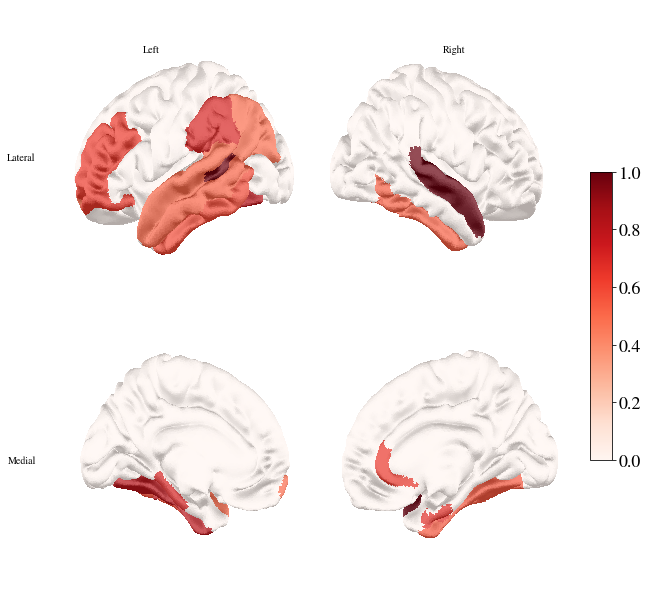

In [20]:
vec = nlogpvals_sini
vec = (vec-vec.min())/(vec.max()-vec.min())
vec[pvals_sini>=0.05] = 0
cmap = "Reds"
fig = _brain_plot(vec, cmap=cmap);
plt.savefig(FIG_ROOT/f"{SAVED_FOLDER}_pval_brain_plot_sinica_unadj.jpg")

# Post logi fitting analysis

In [20]:
from utils.misc import bcross_entropy_loss
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
#post_lams = [0.01, 0.02, 0.03,  0.04, 0.05, 0.06, 0.07, 0.1]
post_lams = [0.001, 0.005, 0.01, 0.02, 0.03,  0.04, 0.05, 0.06, 0.07, 0.1]
Ns = [4, 6, 8, 10, 12, 14]
seed = 0
num_fold = 2
np.random.seed(seed)
full_idx = np.arange(len(Yb))
np.random.shuffle(full_idx)
save_pkl(save_dir/f"shuffled_seed{seed}_full_idx_postlogi.pkl", full_idx, is_force=False)
midfile_dir = MIDRES_ROOT/SAVED_FOLDER;

/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../results/real_data_nlinear_nostd/shuffled_seed0_full_idx_postlogi.pkl exists! Use is_force=True to save it anyway


In [21]:

def _get_err_mat(prefix, path=save_dir):
    def _extract_err1(lam, N, prefix="hdf"):
        fil = path/f"{prefix}_postlogi-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
        hdf_res = load_pkl(fil, verbose=False);
        #err = bcross_entropy_loss(hdf_res.cv_Y_est, hdf_res.Y.numpy())
        err = 1-roc_auc_score(hdf_res.Y.numpy(), hdf_res.cv_Y_est)
        return err
    err_mat = np.zeros((len(Ns),len(post_lams)))
    for ix, N in enumerate(Ns):
        for iy, lam in enumerate(post_lams):
            err_mat[ix, iy] = _extract_err1(lam, N, prefix)
    return err_mat

In [22]:
full_idx = load_pkl(save_dir/f"shuffled_seed{seed}_full_idx_postlogi.pkl");
sig_roi_idxs = load_pkl(save_dir/f"sig_roi_idxs.pkl");
n = len(full_idx)
n_perfold = int(n/num_fold);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../results/real_data_nlinear_nostd/shuffled_seed0_full_idx_postlogi.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../results/real_data_nlinear_nostd/sig_roi_idxs.pkl


In [23]:
err_mats = []
hdf_probs= np.zeros(n)
for cv_ix in trange(num_fold):
    test_idx = full_idx[(cv_ix*n_perfold):(cv_ix*n_perfold+n_perfold)]
    if cv_ix == num_fold-1:
        test_idx = full_idx[(cv_ix*n_perfold):]
    tZ = all_data.Z[test_idx] 
    tX = all_data.X[test_idx][:, sig_roi_idxs] 
    tY = all_data.Y[test_idx]
    
    err_mat = _get_err_mat(f"hdf_cv{cv_ix+1}-{num_fold}", path=midfile_dir)
    curN, curlam = _Nlam_localmin(err_mat, Ns, post_lams)
    curhdf_res = load_pkl(midfile_dir/(f"hdf_cv{cv_ix+1}-{num_fold}_postlogi"
                                      f"-lam_{curlam*1000:.0f}"
                                       f"-N_{curN:.0f}_fit.pkl"));
    hdf_probs[test_idx] = curhdf_res.predict(tX, tZ)

 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1/2 [00:01<00:01,  1.55s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../mid_results/real_data_nlinear_nostd/hdf_cv1-2_postlogi-lam_40-N_14_fit.pkl


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../mid_results/real_data_nlinear_nostd/hdf_cv2-2_postlogi-lam_40-N_8_fit.pkl


In [24]:
roc_auc_score(Yb, hdf_probs)

0.8780487804878048

In [25]:
def get_cv_result(X, Y, num_fold, Cs, seed=1):
    np.random.seed(seed)
    def _get_optC(Cs, X, Y, num_fold4C=2):
        aucs = []
        for C in Cs:
            clf = LogisticRegression(C=C, fit_intercept=is_nointe)
            est_probs1 = cross_val_predict(clf, X, Y, cv=num_fold4C, method="predict_proba")[:, 1];
            aucs.append(roc_auc_score(Y, est_probs1))
        optC = Cs[np.argmax(aucs)]
        return optC
    
    n = len(Y)
    con_idxs = [len(np.unique(X[:, cov_ix])) >= (0.9*n) for cov_ix in range(X.shape[1])]
    is_nointe = np.sum(X[:, 0] != 1) != 0
    full_idx = np.arange(n)
    np.random.shuffle(full_idx)
    n_perfold = int(n/num_fold)
    est_probs_full = np.zeros(n)
    for idx in range(num_fold):
        test_idx = full_idx[(idx*n_perfold):(idx*n_perfold+n_perfold)]
        if idx == num_fold - 1:
            test_idx = full_idx[(idx*n_perfold):]
        train_idx = np.setdiff1d(full_idx, test_idx)
        trY = Y[train_idx]
        trX = X[train_idx]
        teY = Y[test_idx]
        teX = X[test_idx]
        # to be done
        
        trX_mean = trX.mean(axis=0, keepdims=True)
        trX_std = trX.std(axis=0, keepdims=True)
        trX[:, con_idxs] =  (trX[:, con_idxs]-trX_mean[:, con_idxs])/trX_std[:, con_idxs]
        teX[:, con_idxs] =  (teX[:, con_idxs]-trX_mean[:, con_idxs])/trX_std[:, con_idxs]
        
        optC = _get_optC(Cs, trX, trY, num_fold4C=10)
        clf = LogisticRegression(C=optC, fit_intercept=is_nointe).fit(trX, trY)
        est_probs = clf.predict_proba(teX)[:, 1]
        est_probs_full[test_idx] = est_probs
        
    return est_probs_full, roc_auc_score(Y, est_probs_full)



In [26]:
Cs = [1e-2, 1e-1, 0.2, 0.4, 0.8, 1]

# now lets fit logi without PSD
pZ = Z[:, :].copy()
sinica_probs, auc = get_cv_result(pZ, Yb, num_fold, Cs, seed=seed);
print(auc)

# now fit with sig psd info from naive way
psd_Z = load_pkl(RES_ROOT/f"{SAVED_FOLDER}/info_from_sig_bands_naive.pkl", verbose=False); 
bZ = np.concatenate([Z, psd_Z], axis=1);
naive_probs, auc = get_cv_result(bZ, Yb, num_fold, Cs, seed=seed);
print(auc)



0.7033186725309876
0.8438624550179928


In [27]:
auc = roc_auc_score(Yb, hdf_probs)
auc0 = roc_auc_score(Yb, naive_probs)
auc1 = roc_auc_score(Yb, sinica_probs)
f1 = f1_score(Yb, hdf_probs>0.5)
f10 = f1_score(Yb, naive_probs>0.5)
f11 = f1_score(Yb, sinica_probs>0.5)
bce = bcross_entropy_loss(hdf_probs, Yb)
bce0 = bcross_entropy_loss(naive_probs, Yb)
bce1 = bcross_entropy_loss(sinica_probs, Yb)

0.6226525656425862

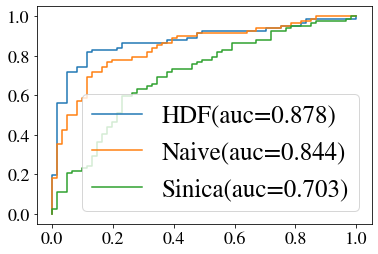

In [29]:
fpr, tpr, _ = roc_curve(Yb, hdf_probs)
fpr0, tpr0, _ = roc_curve(Yb, naive_probs)
fpr1, tpr1, _ = roc_curve(Yb, sinica_probs)
plt.plot(fpr, tpr, label=f"HDF(auc={auc:.3f})")
plt.plot(fpr0, tpr0, label=f"Naive(auc={auc0:.3f})")
plt.plot(fpr1, tpr1, label=f"Sinica(auc={auc1:.3f})")
plt.legend()